# 一連の予測を行うNotebook
## ライブラリのインポート

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb

sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))
from conf.config import CFG, DIRS

from utils.load_datas import load_all_datas
from utils.feature_enginerring2 import feature_engineering_prototype2
from utils.validations import cross_val_train, walk_forward_time_val, time_cross_val
from utils.lgb_trial import new_tuning

## 設定

In [2]:
config = CFG()

# データのロード
train_df, test_df = load_all_datas()

# 変換
train_df, test_df = feature_engineering_prototype2(train_df, test_df, config)

# 切り分け
X_train_pp = train_df.loc[:, config.FEATURES]
y_train = train_df.loc[:, config.TARGET]
X_test_pp = test_df.loc[:, config.FEATURES]

# パラメータの設定
params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "learning_rate": 0.05,
    "max_depth": 5,
    "min_child_weight": 1.0,
    "bagging_fraction": 0.8, # subsampleと同義
    "feature_fraction": 0.8, # colsample_bytreeと同義
    "random_state": config.SEED, 
}

## 予測

In [4]:
val_scores, model = time_cross_val(X_train_pp, y_train, params, config)
print(f"Mean RMSLE: {np.mean(val_scores):.5f}")

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	valid_0's rmse: 3572.91
Fold: 2   Train RMSLE: 3082.6241  Val RMSLE: 3572.9073
--------------------------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[313]	valid_0's rmse: 4087.27
Fold: 3   Train RMSLE: 1520.9619  Val RMSLE: 4087.2698
--------------------------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[193]	valid_0's rmse: 4715.16
Fold: 4   Train RMSLE: 2405.6996  Val RMSLE: 4715.1594
--------------------------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[318]	valid_0's rmse: 4461.89
Fold: 5   Train RMSLE: 2111.0291  Val RMSLE: 4461.8880
--------------------------------------------------
Mean RMSLE: 4209.30613


In [5]:
# 再度訓練を行う
dtrain, dest = (
            lgb.Dataset(
                data=X_train_pp,
                label=y_train,
                feature_name=config.FEATURES,
                categorical_feature=config.CAT_FEATURES,
            ),
            lgb.Dataset(
                data=X_test_pp,
                feature_name=config.FEATURES,
                categorical_feature=config.CAT_FEATURES,
            ),
        )

final_model = lgb.train(params, dtrain, num_boost_round=60)

In [7]:
test_preds = final_model.predict(X_test_pp)

## 特徴量重要性

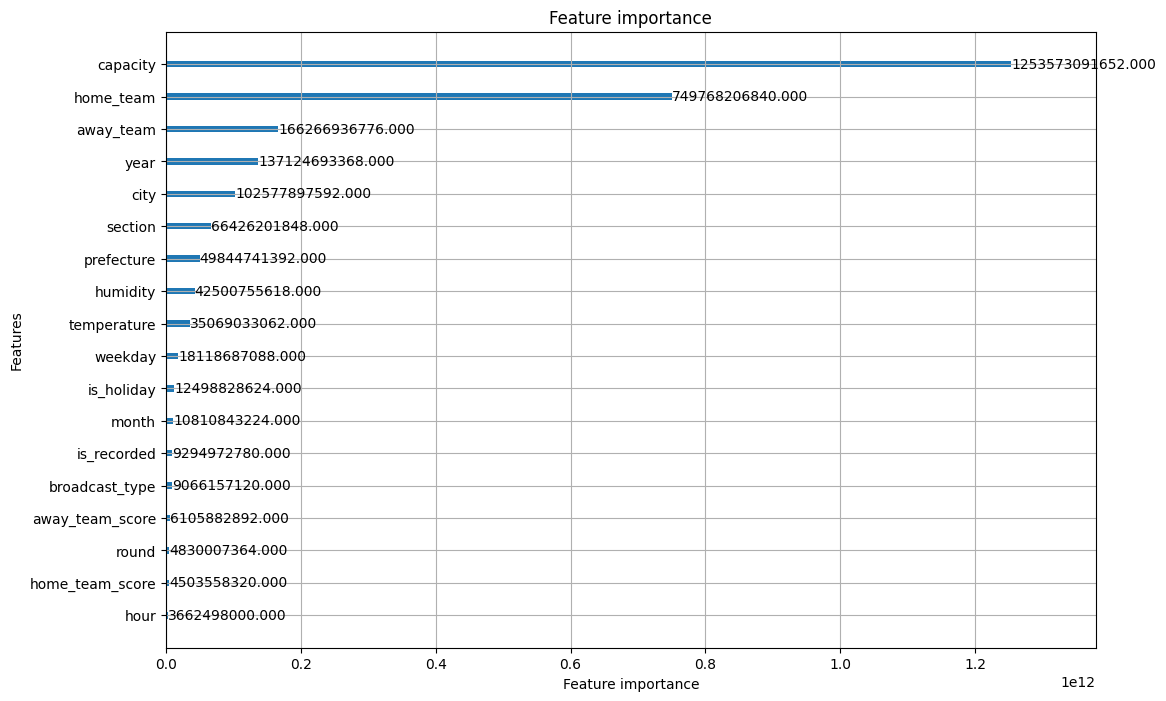

In [6]:
lgb.plot_importance(final_model, importance_type="gain", figsize=(12, 8))
plt.show()

## submitの作成

In [8]:
sub = pd.DataFrame({
    "id": test_df["id"],
    "attendance": test_preds,
})

sub.to_csv(os.path.join(DIRS["OUTPUT"], "submission_prototype2_base2.csv"), index=False, header=None)

結果は**5425.87**となった。<br>
明らかな過学習を起こしている。バリデーションの方法の見直しを行う